#XGBoost

# Assignment 3
Problem Statement: Feature Selection using gradient boosting

Dataset Used: PIMA-Diabetes Dataset in India

ML Model: XGBoost Classifier

Performance of model : (Metric taken : f1_score)


1.   Without feature selection : 0.60
2.   With feature selection : 0.69 (approximately)



In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
col_names = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'Class']
data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/pima-indians-diabetes.csv", names = col_names)

In [ ]:
dataset = data.iloc[:100, :]
dataset

,A,B,C,D,E,F,G,H,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
95,6,144,72,27,228,33.9,0.255,40,0
96,2,92,62,28,0,31.6,0.130,24,0
97,1,71,48,18,76,20.4,0.323,22,0
98,6,93,50,30,64,28.7,0.356,23,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       100 non-null    int64  
 1   B       100 non-null    int64  
 2   C       100 non-null    int64  
 3   D       100 non-null    int64  
 4   E       100 non-null    int64  
 5   F       100 non-null    float64
 6   G       100 non-null    float64
 7   H       100 non-null    int64  
 8   Class   100 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 7.2 KB


In [ ]:
dataset['Class'].value_counts()

0    63
1    37
Name: Class, dtype: int64

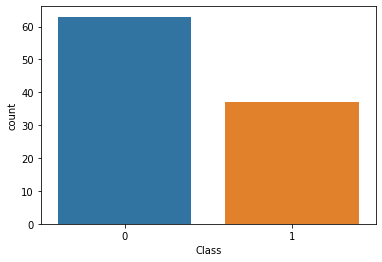

In [ ]:
import seaborn as sns 
sns.countplot(x='Class', data=dataset)
plt.show()

Two issues noticed:
*  Slight Class imbalance
*  Non-Standardized values causing a bias.




In [ ]:
# Column Class is our target of variables
y = dataset['Class'] #target
x = dataset.drop(['Class'], axis=1) #Features

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

In [ ]:
scaler = scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
temp = pd.DataFrame(x_train)
temp.head()

,0,1,2,3,4,5,6,7
0,0.769231,0.852792,0.672727,0.000000,0.000000,0.764588,0.259083,0.333333
1,0.153846,0.360406,0.636364,0.450000,0.000000,0.563380,0.288267,0.025641
2,0.153846,0.558376,0.672727,0.483333,0.147754,0.651911,0.354973,0.153846
3,1.000000,0.736041,0.745455,0.316667,0.130024,0.446680,0.085170,0.923077
4,0.307692,0.680203,0.654545,0.000000,0.000000,0.478873,0.104229,1.000000


In [ ]:
y_train.value_counts()

0    46
1    24
Name: Class, dtype: int64

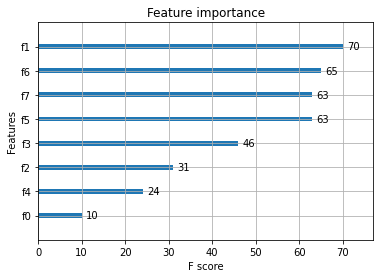

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier(random_state=0)
model.fit(x_train, y_train)

plot_importance(model)
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(model)
selection.fit(x_train, y_train)

SelectFromModel(estimator=XGBClassifier())

In [ ]:
selection_x_train = selection.transform(x_train)
selection_x_test = selection.transform(x_test)

In [ ]:
selection_model = XGBClassifier()
selection_model.fit(selection_x_train, y_train)

XGBClassifier()

In [ ]:
#baseline model accuracy
from sklearn.metrics import roc_auc_score, f1_score

y_pred = model.predict(x_test)
print("The feature dimension of dataset without feature selection: ", x_test.shape)
print("accuracy score = ", roc_auc_score(y_test, y_pred))
print("f1 score = ", f1_score(y_test, y_pred))

The feature dimension of dataset without feature selection:  (30, 8)
accuracy score =  0.7194570135746606
f1 score =  0.6666666666666667


In [ ]:
y_pred_xgb = selection_model.predict(selection_x_test)
print("The feature dimenstion of dataset with xgb feature selection : ", selection_x_test.shape)
print("accuracy score = ", accuracy_score(y_test, y_pred_xgb))
print("f1 score = ", f1_score(y_test, y_pred_xgb))

The feature dimenstion of dataset with xgb feature selection :  (30, 5)
accuracy score =  0.7
f1 score =  0.608695652173913


In [ ]:
selection_x_train.shape

(70, 5)

Upon experimentation of the issues:
*  Normalizing the data gave no change in the accuracy metric
*  sampling the imbalanced dataset (using SMOTE) gave the same accuracy as the metric with the xgboosted dataset. (f1_score of ~0.61)

Trying out other models for prediction

In [ ]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state = 0)
model_lr = model_lr.fit(selection_x_train, y_train)
y_pred_lr = model_lr.predict(selection_x_test)
print(f1_score(y_test, y_pred_lr))

0.4444444444444444


This is way too low compared to xgboost

Coming back to xgboost, let us start tuning the hyperparameters using GridSearchCV.

In [ ]:
#checking in baseline performance
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RepeatedStratifiedKFold
weights = [1, 10, 25, 50, 75, 99, 100, 101, 999, 1000]
param_grid = dict(scale_pos_weight = weights)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=selection_model, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(selection_x_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.825556 using {'scale_pos_weight': 101}
0.780556 (0.177956) with: {'scale_pos_weight': 1}
0.812778 (0.185077) with: {'scale_pos_weight': 10}
0.815000 (0.203504) with: {'scale_pos_weight': 25}
0.815000 (0.192611) with: {'scale_pos_weight': 50}
0.815000 (0.184709) with: {'scale_pos_weight': 75}
0.818889 (0.182662) with: {'scale_pos_weight': 99}
0.824444 (0.170225) with: {'scale_pos_weight': 100}
0.825556 (0.183118) with: {'scale_pos_weight': 101}
0.812778 (0.168363) with: {'scale_pos_weight': 999}
0.809444 (0.173455) with: {'scale_pos_weight': 1000}


The best performance of the model is produced at scale_pos_weight=1000, which is very close to the baseline model accuracy.

In [ ]:
selection_model_new = XGBClassifier(scale_pos_weight = 101)
selection_model_new.fit(selection_x_train, y_train)
y_pred_new = selection_model_new.predict(selection_x_test)

In [ ]:
print("The feature dimenstion of dataset with xgb feature selection : ", selection_x_test.shape)
print("accuracy score = ", roc_auc_score(y_test, y_pred_new))
print("f1 score = ", f1_score(y_test, y_pred_new))

The feature dimenstion of dataset with xgb feature selection :  (30, 5)
accuracy score =  0.6877828054298643
f1 score =  0.6875


Here, we got an much improved f1_score compared to the baseline but a slightly lesser roc_auc accuracy score than before, nonetheless it does count as a slight improvement in performance.  